In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
from sklearn.metrics import mean_squared_error, r2_score
import math



def getProb(odds):
    return (math.e**odds)/(1+(math.e**odds))

def getResiduals(predicted,actual):
    residuals = []
    for i in range(len(predicted)):
        residuals[i] = actual[i] - predicted[i]

def getModel(nodes,x,pseudoResiduals):
    #create tree with our pseudoResiduals
    from sklearn.tree import DecisionTreeRegressor
    model = DecisionTreeRegressor(max_leaf_nodes=nodes)
    model.fit(x,pseudoResiduals)


    #Get index of leaf where each test case goes
    idxLeaf = model.apply(x)

    up = np.zeros(len(idxLeaf))
    down = np.zeros(len(idxLeaf))
    #print("len leafs",len(idxLeaf))
    #print("len Up",len(up))
    #print("len residuals",len(pseudoResiduals))
    for i in range(0,len(idxLeaf)):
        #print(i,pseudoResiduals[i])
        up[idxLeaf[i]] += pseudoResiduals[i]
        down[idxLeaf[i]] += getProb(pseudoResiduals[i]) * (1-getProb(pseudoResiduals[i]))

    newLeafPrediction = np.zeros(len(idxLeaf))
    for i in range(0,len(idxLeaf)):
        if down[i] != 0:
            model.tree_.value[i,0,0] = up[i]/down[i]
            newLeafPrediction[i] = up[i]/down[i]
    return model

def predict(models,x,learningRate,average):
    odds = average
    for i in range(len(models)):
        odds += learningRate*models[i].predict(x)
    return getProb(odds)
    #print(odds)
    #print(getProb(odds))

# Import train_test_split function
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score

learningRate = 0.001
nodes = 16
numTrees = 10
df = pd.read_csv("wine_quality.csv", true_values=["high"], false_values=["low"])
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)
df.drop(df.filter(regex="X"),axis=1, inplace=True)
#df.drop('alcohol_level',axis=1, inplace=True)
df["quality"] = df["quality"].astype(int)
df = df.dropna()
x = df.drop('quality',axis=1)
y = df.quality
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=109) # 70% training and 30% test

#Returns f1_score, accuracy,averageResidual
def buildAndTest(X_train,y_train,X_test,y_test,learningRate,nodes,numTrees):
    #Get average for the model and first residuals
    average = math.log((y_train==1).sum()/(y_train==0).sum())
    pseudoResiduals = np.zeros(len(y_train))
    for i in range(0,len(pseudoResiduals)):
        pseudoResiduals[i] = y_train.iloc[i] - getProb(average)

    models = []
    for i in range(0,numTrees):
        models.append(getModel(nodes,X_train,pseudoResiduals))
        modelPredictions = models[i].predict(X_train)
        predictions = np.zeros(len(pseudoResiduals))
        for i in range(len(pseudoResiduals)):
            predictions[i] = getProb(pseudoResiduals[i] + learningRate * modelPredictions[i])

        for i in range(0,len(pseudoResiduals)):
            pseudoResiduals[i] = y_train.iloc[i] - predictions[i]

    #learninRateResiduals.append(abs(pseudoResiduals.sum())/len(pseudoResiduals))
    res = predict(models,X_test,learningRate,average)
    predicted = []
    for i in range(0,len(res)):
        if res[i] > 0.5:
            predicted.append(1)
        else:
            predicted.append(0)
    #learninRateF1.append(f1_score(y_test,predicted))
    #learningRateAccuracy.append(accuracy_score(y_test,predicted))
    return f1_score(y_test,predicted),accuracy_score(y_test,predicted),(abs(pseudoResiduals.sum())/len(pseudoResiduals))

#print(buildAndTest(X_train,y_train,X_test,y_test,0.971,16,10))



Best learning rate 0.965


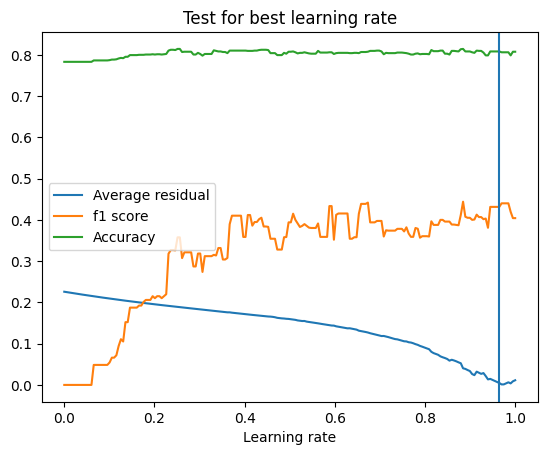

Best num trees 8


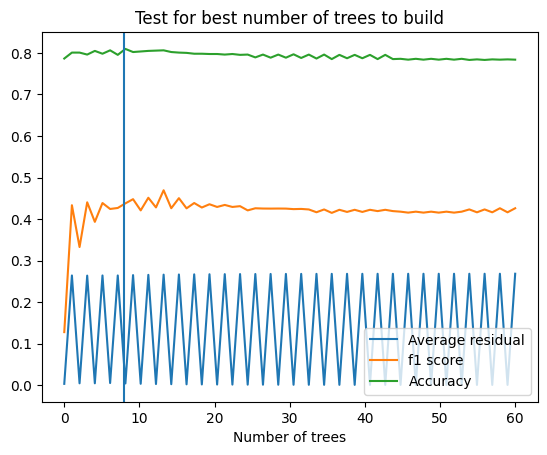

Best num of leafs 97


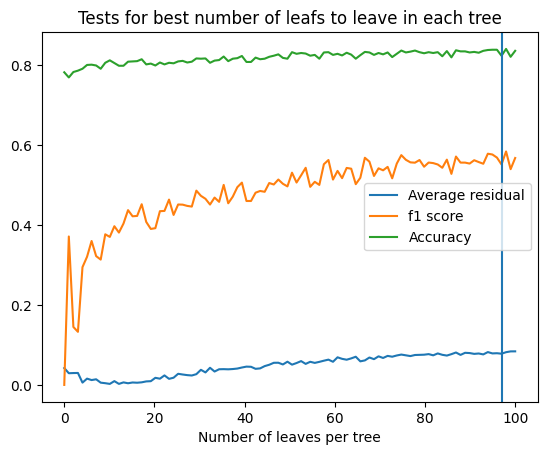

" The model does not overfit, becuase we set the max number of leafs for each tree we build. We are back prunning so we don't overfit. We also set the max number of trees we build."

In [2]:
import matplotlib.pyplot as plt

F1Score = []
Residuals = []
Accuracy = []
learningRate = 0.005
for i in range(0,200):
    #if i%50 == 0:
    #    print(learningRate)
    learningRate += 0.005
    f1,acc,res = buildAndTest(X_train, y_train, X_test, y_test,learningRate,16,10)
    F1Score.append(f1)
    Accuracy.append(acc)
    Residuals.append(res)

best = np.array(F1Score)+np.array(Accuracy)-np.array(Residuals)
print("Best learning rate",np.where(best==best.max())[0][0]/200)
plt.title("Test for best learning rate")
plt.plot(np.linspace(0,1,200),Residuals,label="Average residual")
plt.plot(np.linspace(0,1,200),F1Score,label="f1 score")
plt.plot(np.linspace(0,1,200),Accuracy,label="Accuracy")
plt.axvline(np.where(best==best.max())[0][0]/200)
plt.xlabel("Learning rate")
plt.legend()
plt.show()

F1Score = []
Residuals = []
Accuracy = []
numTrees = 1
for i in range(0,60):
    numTrees += 1
    f1,acc,res = buildAndTest(X_train, y_train, X_test, y_test,0.971,16,numTrees)
    F1Score.append(f1)
    Accuracy.append(acc)
    Residuals.append(res)

best = np.array(F1Score)+np.array(Accuracy)-np.array(Residuals)
print("Best num trees",np.where(best==best.max())[0][0])
plt.title("Test for best number of trees to build")
plt.plot(np.linspace(0,60,60),Residuals,label="Average residual")
plt.plot(np.linspace(0,60,60),F1Score,label="f1 score")
plt.plot(np.linspace(0,60,60),Accuracy,label="Accuracy")
plt.axvline(np.where(best==best.max())[0][0])
plt.xlabel("Number of trees")
plt.legend()
plt.show()

F1Score = []
Residuals = []
Accuracy = []
numLeafs = 1
for i in range(0,100):
    numLeafs += 1
    f1,acc,res = buildAndTest(X_train, y_train, X_test, y_test,0.971,numLeafs,10)
    F1Score.append(f1)
    Accuracy.append(acc)
    Residuals.append(res)

best = np.array(F1Score)+np.array(Accuracy)-np.array(Residuals)
print("Best num of leafs",np.where(best==best.max())[0][0])
plt.title("Tests for best number of leafs to leave in each tree")
plt.plot(np.linspace(0,100,100),Residuals,label="Average residual")
plt.plot(np.linspace(0,100,100),F1Score,label="f1 score")
plt.plot(np.linspace(0,100,100),Accuracy,label="Accuracy")
plt.axvline(np.where(best==best.max())[0][0])
plt.xlabel("Number of leaves per tree")
plt.legend()
plt.show()
# COMMENT ABOUT OVERFITTING
""" The model does not overfit, becuase we set the max number of leafs for each tree we build. We are back prunning so we don't overfit. We also set the max number of trees we build."""

In [3]:
def k_fold(X, y, fold):
    f1Score = 0
    accuracy = 0
    residuals = 0
    counter = 0
    step_size = int(X.shape[0]/fold)
    for i in range(0,X.shape[0]-step_size,step_size):
        testX = X[i:i+step_size]        
        testY = y[i:i+step_size]    
        trainX = X[0:i]
        trainX = trainX.append(X[i+step_size+1:], ignore_index=True)        
        trainY = y[0:i]
        trainY = trainY.append(y[i+step_size+1:], ignore_index=True)
        f1,acc,resid = buildAndTest(trainX, trainY, testX, testY,1,16,10)
        f1Score += f1
        accuracy += acc
        residuals += resid
        counter += 1
    return (f1Score/counter),(accuracy/counter),(residuals/counter)

def k_fold_sci(X, y, fold):
    from sklearn.ensemble import GradientBoostingClassifier
    f1Score = 0
    accuracy = 0
    counter = 0
    step_size = int(X.shape[0]/fold)
    for i in range(0,X.shape[0]-step_size,step_size):
        testX = X[i:i+step_size]        
        testY = y[i:i+step_size]    
        trainX = X[0:i]
        trainX = trainX.append(X[i+step_size+1:], ignore_index=True)        
        trainY = y[0:i]
        trainY = trainY.append(y[i+step_size+1:], ignore_index=True)
        clf = GradientBoostingClassifier(random_state=0).fit(trainX, trainY)
        res = clf.predict(testX)
        f1Score += f1_score(res,testY)
        accuracy += accuracy_score(res,testY)
        counter += 1
    return (f1Score/counter),(accuracy/counter)




In [4]:

def k_fold_xgboost(X, y, fold):
    import xgboost as xgb
    f1Score = 0
    accuracy = 0
    counter = 0
    step_size = int(X.shape[0]/fold)
    for i in range(0,X.shape[0]-step_size,step_size):
        testX = X[i:i+step_size]        
        testY = y[i:i+step_size]    
        trainX = X[0:i]
        trainX = trainX.append(X[i+step_size+1:], ignore_index=True)        
        trainY = y[0:i]
        trainY = trainY.append(y[i+step_size+1:], ignore_index=True)
        clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
        clf.fit(trainX,trainY)
        res = clf.predict(testX)
        f1Score += f1_score(res,testY)
        accuracy += accuracy_score(res,testY)
        counter += 1
    return (f1Score/counter),(accuracy/counter)

def k_fold_lgbm(X, y, fold):
    from lightgbm import LGBMClassifier
    f1Score = 0
    accuracy = 0
    counter = 0
    step_size = int(X.shape[0]/fold)
    for i in range(0,X.shape[0]-step_size,step_size):
        testX = X[i:i+step_size]        
        testY = y[i:i+step_size]    
        trainX = X[0:i]
        trainX = trainX.append(X[i+step_size+1:], ignore_index=True)        
        trainY = y[0:i]
        trainY = trainY.append(y[i+step_size+1:], ignore_index=True)
        clf = LGBMClassifier(objective='binary',random_state=5,verbose = 0)
        clf.fit(trainX,trainY)
        res = clf.predict(testX)
        f1Score += f1_score(res,testY)
        accuracy += accuracy_score(res,testY)
        counter += 1
    return (f1Score/counter),(accuracy/counter)

def k_fold_catboost(X, y, fold):
    from catboost import CatBoostClassifier
    f1Score = 0
    accuracy = 0
    counter = 0
    step_size = int(X.shape[0]/fold)
    for i in range(0,X.shape[0]-step_size,step_size):
        testX = X[i:i+step_size]        
        testY = y[i:i+step_size]    
        trainX = X[0:i]
        trainX = trainX.append(X[i+step_size+1:], ignore_index=True)        
        trainY = y[0:i]
        trainY = trainY.append(y[i+step_size+1:], ignore_index=True)
        clf = CatBoostClassifier(random_state=5,verbose = 0)
        clf.fit(trainX,trainY)
        res = clf.predict(testX)
        f1Score += f1_score(res,testY)
        accuracy += accuracy_score(res,testY)
        counter += 1
    return (f1Score/counter),(accuracy/counter)

scores = k_fold(x,y,10)
scores_sci = k_fold_sci(x,y,10)
scores_xgb = k_fold_xgboost(x,y,10)
scores_lgbm = k_fold_lgbm(x,y,10)
scores_catb = k_fold_catboost(x,y,10)
print("ALL MODELS TESTED ON 10 FOLDS")
print("Our model")
print("Accuracy",scores[1],"f1 score",scores[0])
print("Scikit")
print("Accuracy",scores_sci[1],"f1 score",scores_sci[0])
print("xgbost")
print("Accuracy",scores_xgb[1],"f1 score",scores_xgb[0])
print("lgbm")
print("Accuracy",scores_lgbm[1],"f1 score",scores_lgbm[0])
print("catboost")
print("Accuracy",scores_catb[1],"f1 score",scores_catb[0])

ALL MODELS TESTED ON 10 FOLDS
Our model
Accuracy 0.8004089979550102 f1 score 0.36463638006631405
Scikit
Accuracy 0.8026584867075665 f1 score 0.40616376632213297
xgbost
Accuracy 0.7989775051124746 f1 score 0.43358614698996645
lgbm
Accuracy 0.8061349693251533 f1 score 0.4440287935949236
catboost
Accuracy 0.8069529652351738 f1 score 0.4279777427805735
